In [1]:
#Data Prepping

import pandas as pd
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("../data/ai4i2020.csv")
df.head()

# How many rows & colums + NaN check
print("Initial shape:", df.shape)
print("\nNaN check:\n", df.isna().sum())

# Drop any NaN rows if exist
df.dropna(inplace=True)
print("\nShape after removing NaN rows:", df.shape)

# Encode product quality labels (L, M, H) numerically as 0, 1 & 2
if 'Type' in df.columns:
    df['Type'] = df['Type'].map({'L': 0, 'M': 1, 'H': 2})

# Select continuous numerical columns
continuous_cols = ['Air temperature [K]', 'Process temperature [K]',
                   'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

# Apply Z-score scaling
scaler_z = StandardScaler()
df_z_scaled = df.copy()
df_z_scaled[continuous_cols] = scaler_z.fit_transform(df[continuous_cols])

# Final output
print("\nZ-score scaled sample:")
print(df_z_scaled.head())

Initial shape: (10000, 14)

NaN check:
 UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

Shape after removing NaN rows: (10000, 14)

Z-score scaled sample:
   UDI Product ID  Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860     1            -0.952389                -0.947360   
1    2     L47181     0            -0.902393                -0.879959   
2    3     L47182     0            -0.952389                -1.014761   
3    4     L47183     0            -0.902393                -0.947360   
4    5     L47184     0            -0.902393                -0.879959   

   Rotational speed [rpm]  Torque 


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip install --upgrade pip
Target distribution (0=L,1=M,2=H): Counter({0: 6000, 1: 2997, 2: 1003})
Target distribution (L/M/H as 0/1/2): Counter({0: 6000, 1: 2997, 2: 1003})

=== Baseline LogReg ===
{'model': 'Baseline LogReg', 'cv_macroF1': 0.25, 'cv_MCC': 0.0, 'cv_macroPR_AUC': 0.3251, 'cv_ROC_AUC_OvR': 0.4866, 'test_macroF1': 0.25, 'test_MCC': 0.0, 'test_macroPR_AUC': 0.3439, 'test_ROC_AUC_OvR': 0.5105}
              precision    recall  f1-score   support

           L     0.6000    1.0000    0.7500      1200
           M     0.0000    0.0000    0.0000       599
           H     0.0000    0.0000    0.0000       201

    accuracy                         0.6000      2000
   macro avg     0.2000    0.3333    0.2500      2000
weighted avg     0.3600    0.6000    0.4500      2000


=== SMOTE + LogReg ===
{'model': 'SMOTE + LogReg', 'cv_macroF1': 0.271, 'cv_MCC': -0.0075, 'cv_macroPR_AUC': 0.3315, 'cv_ROC_A

/opt/anaconda3/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/opt/anaconda3/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/opt/anaconda3/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/


=== BalancedRandomForest ===
{'model': 'BalancedRandomForest', 'cv_macroF1': 0.2899, 'cv_MCC': -0.0038, 'cv_macroPR_AUC': 0.3347, 'cv_ROC_AUC_OvR': 0.4989, 'test_macroF1': 0.3026, 'test_MCC': 0.0156, 'test_macroPR_AUC': 0.3381, 'test_ROC_AUC_OvR': 0.5179}
              precision    recall  f1-score   support

           L     0.5936    0.2933    0.3926      1200
           M     0.3126    0.3439    0.3275       599
           H     0.1190    0.4428    0.1876       201

    accuracy                         0.3235      2000
   macro avg     0.3417    0.3600    0.3026      2000
weighted avg     0.4617    0.3235    0.3525      2000



,model,cv_macroF1,cv_MCC,cv_macroPR_AUC,cv_ROC_AUC_OvR,test_macroF1,test_MCC,test_macroPR_AUC,test_ROC_AUC_OvR
3,SMOTE + RandomForest,0.329789,-0.008603,0.333234,0.498557,0.326950,-0.008705,0.344229,0.526590
0,Baseline LogReg,0.250000,0.000000,0.325076,0.486576,0.250000,0.000000,0.343892,0.510509
1,SMOTE + LogReg,0.271005,-0.007546,0.331487,0.493875,0.285101,0.015820,0.342167,0.516171
2,ClassWeight LogReg,0.253455,-0.019396,0.330911,0.494315,0.278339,0.016534,0.341136,0.513036
4,BalancedRandomForest,0.289889,-0.003782,0.334739,0.498896,0.302569,0.015579,0.338055,0.517859


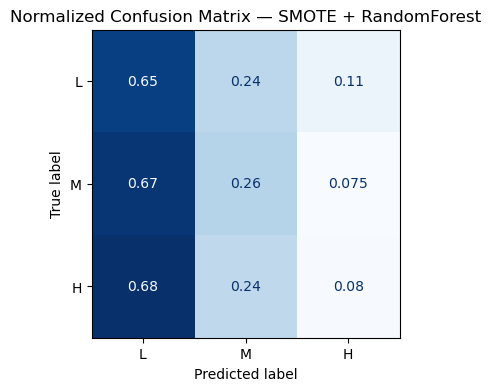

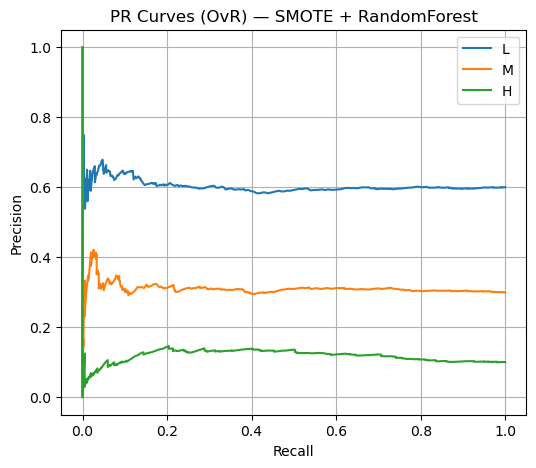

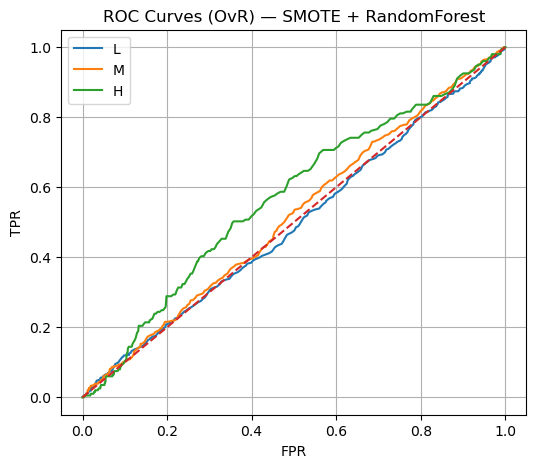

Saved: failure_imbalance_comparison.csv


In [ ]:
#Multiclass L/M/H (Quality) Pipeline
!pip -q install imbalanced-learn

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, matthews_corrcoef, f1_score,
    roc_auc_score, average_precision_score, precision_recall_curve, roc_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier

# 1) Load and define target/features (NO leakage)
# Reuse an existing df if present; otherwise read the CSV in the working dir.
if 'df' not in globals():
    df = pd.read_csv('ai4i2020.csv')

# Target: Quality "Type" with values L/M/H
# robust target extraction for Type (L/M/H)
assert 'Type' in df.columns, "Missing 'Type' column."

t = df['Type']

def coerce_type_to_012(s):
    # case 1: already numeric 0/1/2
    try:
        vals = pd.to_numeric(s, errors='coerce')
        if set(pd.unique(vals.dropna())) <= {0,1,2}:
            return vals.astype(int).to_numpy()
    except Exception:
        pass

    # case 2: strings like 'L','M','H' (with potential spaces/mixed case)
    s2 = s.astype(str).str.strip().str.upper()
    mapped = s2.map({'L':0, 'M':1, 'H':2})
    if mapped.isna().any():
        print("Unrecognized Type values:",
              sorted(s2[mapped.isna()].unique().tolist())[:20])
        raise ValueError("Type contains values other than L/M/H or 0/1/2.")
    return mapped.astype(int).to_numpy()

y = coerce_type_to_012(t)

from collections import Counter
print("Target distribution (0=L,1=M,2=H):", Counter(y))


# Use only sensor/process features to avoid leakage from IDs and failure labels
sensor_cols = ['Air temperature [K]','Process temperature [K]',
               'Rotational speed [rpm]','Torque [Nm]','Tool wear [min]']
X = df[sensor_cols].copy()

print("Target distribution (L/M/H as 0/1/2):", Counter(y))

# 2) Split and scaler
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
scaler = StandardScaler()

# 3) Strategies (imbalance handling for multiclass)
# Note:
# - SMOTE works in multiclass via OvR under the hood.
# - Class weights are applied per-class in the base estimator.
# - BalancedRandomForest performs class-balanced resampling inside each tree.
strategies = {
    "Baseline LogReg": ImbPipeline([
        ('sc', scaler),
        ('clf', LogisticRegression(max_iter=2000))
    ]),
    "SMOTE + LogReg": ImbPipeline([
        ('sc', scaler),
        ('smote', SMOTE(random_state=42)),
        ('clf', LogisticRegression(max_iter=2000))
    ]),
    "ClassWeight LogReg": ImbPipeline([
        ('sc', scaler),
        ('clf', LogisticRegression(max_iter=2000, class_weight='balanced'))
    ]),
    "SMOTE + RandomForest": ImbPipeline([
        ('sc', scaler),
        ('smote', SMOTE(random_state=42)),
        ('clf', RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1))
    ]),
    "BalancedRandomForest": ImbPipeline([
        ('sc', scaler),
        ('clf', BalancedRandomForestClassifier(
            n_estimators=600, random_state=42, n_jobs=-1
        ))
    ]),
}

# 4) Cross-validation helper (stratified) - FIXED VERSION
def cv_scores_multiclass(model, X, y, cv=5):
    """
    Returns mean macro-F1, MCC, macro PR-AUC, and ROC-AUC (OvR) via stratified K-fold CV.
    For PR/ROC AUC we use probability estimates and one-vs-rest aggregation.
    """
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    f1_list, mcc_list, prauc_list, rocauc_list = [], [], [], []
    
    for tr, va in skf.split(X, y):
        model.fit(X.iloc[tr], y[tr])
        prob = model.predict_proba(X.iloc[va])  # shape [n, 3]
        pred = np.argmax(prob, axis=1)
        
        # macro-F1 & MCC (multiclass)
        f1_list.append(f1_score(y[va], pred, average='macro'))
        mcc_list.append(matthews_corrcoef(y[va], pred))
        
        # FIXED: Binarize labels for PR-AUC calculation
        y_val_bin = label_binarize(y[va], classes=[0, 1, 2])
        
        # Calculate PR-AUC for each class and average
        pr_aucs = []
        for i in range(3):
            pr_aucs.append(average_precision_score(y_val_bin[:, i], prob[:, i]))
        prauc_list.append(np.mean(pr_aucs))
        
        # ROC-AUC with OvR (this one already works)
        rocauc_list.append(roc_auc_score(y[va], prob, multi_class='ovr', average='macro'))
    
    return float(np.mean(f1_list)), float(np.mean(mcc_list)), float(np.mean(prauc_list)), float(np.mean(rocauc_list))

# 5) Run all strategies, evaluate on test, collect results
rows, prob_store = [], {}
for name, pipe in strategies.items():
    cv_f1, cv_mcc, cv_pr, cv_roc = cv_scores_multiclass(pipe, X_train, y_train, cv=5)
    pipe.fit(X_train, y_train)
    prob = pipe.predict_proba(X_test)
    pred = np.argmax(prob, axis=1)

    test_macro_f1 = f1_score(y_test, pred, average='macro')
    test_mcc      = matthews_corrcoef(y_test, pred)
    
    # FIXED: Binarize labels for test PR-AUC calculation
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
    test_pr_aucs = []
    for i in range(3):
        test_pr_aucs.append(average_precision_score(y_test_bin[:, i], prob[:, i]))
    test_pr_auc = np.mean(test_pr_aucs)
    
    test_roc_auc  = roc_auc_score(y_test, prob, multi_class='ovr', average='macro')

    row = {
        "model": name,
        "cv_macroF1": cv_f1,
        "cv_MCC": cv_mcc,
        "cv_macroPR_AUC": cv_pr,
        "cv_ROC_AUC_OvR": cv_roc,
        "test_macroF1": test_macro_f1,
        "test_MCC": test_mcc,
        "test_macroPR_AUC": test_pr_auc,
        "test_ROC_AUC_OvR": test_roc_auc
    }
    rows.append(row)
    prob_store[name] = prob

    print(f"\n=== {name} ===")
    print({k: round(v,4) if isinstance(v, float) else v for k,v in row.items()})
    print(classification_report(y_test, pred, digits=4, target_names=['L','M','H'], zero_division=0))

df_res = pd.DataFrame(rows).sort_values(
    by=["test_macroPR_AUC","test_macroF1","test_MCC","test_ROC_AUC_OvR"],
    ascending=False
)
display(df_res)

# 6) Confusion matrix (best model)
best_name = df_res.iloc[0]['model']
best_prob = prob_store[best_name]
best_pred = np.argmax(best_prob, axis=1)
cm = confusion_matrix(y_test, best_pred, labels=[0,1,2], normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['L','M','H'])
fig, ax = plt.subplots(figsize=(5,4))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
plt.title(f'Normalized Confusion Matrix — {best_name}')
plt.show()

# 7) OvR curves for the best model
# PR curves (one-vs-rest) per class
fig = plt.figure(figsize=(6,5))
for c, cname in enumerate(['L','M','H']):
    P, R, _ = precision_recall_curve((y_test==c).astype(int), best_prob[:,c])
    plt.plot(R, P, label=cname)
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title(f'PR Curves (OvR) — {best_name}')
plt.grid(True); plt.legend(); plt.show()

# ROC curves (one-vs-rest) per class
fig = plt.figure(figsize=(6,5))
for c, cname in enumerate(['L','M','H']):
    fpr, tpr, _ = roc_curve((y_test==c).astype(int), best_prob[:,c])
    plt.plot(fpr, tpr, label=cname)
plt.plot([0,1],[0,1],'--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title(f'ROC Curves (OvR) — {best_name}')
plt.grid(True); plt.legend(); plt.show()

# 8) Export table
df_res.to_csv('../data/failure_imbalance_comparison.csv', index=False)
print('Saved: failure_imbalance_comparison.csv')


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip install --upgrade pip
Class distribution (overall): Counter({0: 9661, 1: 339})


/opt/anaconda3/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/opt/anaconda3/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/opt/anaconda3/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/


=== BalancedRF ===
{'model': 'BalancedRF', 'cv_ROC_AUC': 0.9701, 'cv_PR_AUC': 0.6489, 'cv_F1': 0.6199, 'cv_MCC': 0.6146, 'test_ROC_AUC': 0.9727, 'test_PR_AUC': 0.6976, 'test_F1': 0.6812, 'test_Recall': 0.6912, 'test_Precision': 0.6714, 'test_MCC': 0.6698, 'test_threshold': 0.88}
Confusion matrix:
 [[1909   23]
 [  21   47]]

=== EasyEnsemble ===
{'model': 'EasyEnsemble', 'cv_ROC_AUC': 0.957, 'cv_PR_AUC': 0.5368, 'cv_F1': 0.5257, 'cv_MCC': 0.5313, 'test_ROC_AUC': 0.9441, 'test_PR_AUC': 0.4828, 'test_F1': 0.5133, 'test_Recall': 0.8529, 'test_Precision': 0.3671, 'test_MCC': 0.5383, 'test_threshold': 0.5111}
Confusion matrix:
 [[1832  100]
 [  10   58]]

=== SMOTE + LogReg ===
{'model': 'SMOTE + LogReg', 'cv_ROC_AUC': 0.8967, 'cv_PR_AUC': 0.4332, 'cv_F1': 0.4615, 'cv_MCC': 0.4489, 'test_ROC_AUC': 0.9082, 'test_PR_AUC': 0.4039, 'test_F1': 0.4444, 'test_Recall': 0.5294, 'test_Precision': 0.383, 'test_MCC': 0.4276, 'test_threshold': 0.8509}
Confusion matrix:
 [[1874   58]
 [  32   36]]

=== 

,model,cv_ROC_AUC,cv_PR_AUC,cv_F1,cv_MCC,test_ROC_AUC,test_PR_AUC,test_F1,test_Recall,test_Precision,test_MCC,test_threshold
5,ClassWeight RF,0.965522,0.749784,0.733846,0.728741,0.961580,0.792931,0.771654,0.720588,0.830508,0.766259,0.346667
0,BalancedRF,0.970081,0.648929,0.619894,0.614608,0.972697,0.697641,0.681159,0.691176,0.671429,0.669844,0.880000
1,EasyEnsemble,0.956960,0.536752,0.525717,0.531304,0.944115,0.482787,0.513274,0.852941,0.367089,0.538289,0.511121
2,SMOTE + LogReg,0.896740,0.433163,0.461520,0.448902,0.908202,0.403896,0.444444,0.529412,0.382979,0.427635,0.850911
4,ClassWeight LogReg,0.896766,0.442077,0.472891,0.458607,0.907989,0.403470,0.443038,0.514706,0.388889,0.425078,0.849992
3,ADASYN + LogReg,0.895096,0.427554,0.459753,0.450990,0.910166,0.393596,0.427083,0.602941,0.330645,0.420827,0.822091


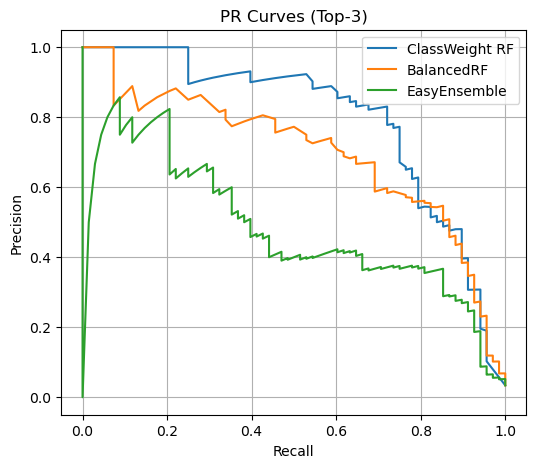

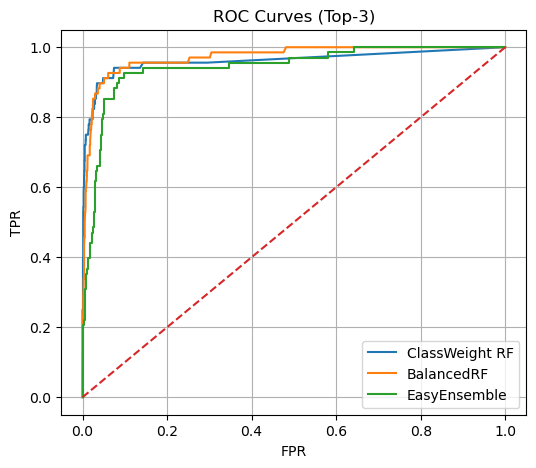

Saved: failure_imbalance_comparison.csv


In [3]:
# Machine failure
!pip -q install imbalanced-learn

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    average_precision_score, roc_auc_score, precision_recall_curve, roc_curve,
    confusion_matrix, classification_report, matthews_corrcoef, f1_score, precision_score, recall_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier

# 1) Load & define target/features (anti-leak)
# If a DataFrame named `df` already exists, reuse it; otherwise read from CSV.
if 'df' not in globals():
    df = pd.read_csv('ai4i2020.csv')

# Target: Machine failure (highly imbalanced ~3.4% positives)
assert 'Machine failure' in df.columns, "Missing 'Machine failure' column"
y = df['Machine failure'].astype(int).values

# Use only process/sensor features to avoid leakage.
# Drop identifiers, quality label, and individual failure-type flags from features.
sensor_cols = ['Air temperature [K]','Process temperature [K]',
               'Rotational speed [rpm]','Torque [Nm]','Tool wear [min]']
X = df[sensor_cols].copy()

print('Class distribution (overall):', Counter(y))

# 2) Split & scaler
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()

# 3) Define models/strategies
# Recommended for extreme imbalance: ensemble methods with built-in resampling,
# plus SMOTE/ADASYN and class_weight baselines for comparison.
strategies = {
    # A) Ensemble methods (recommended)
    'BalancedRF': ImbPipeline([
        ('sc', scaler),
        ('clf', BalancedRandomForestClassifier(
            n_estimators=600, max_depth=None, random_state=42, n_jobs=-1
        ))
    ]),
    'EasyEnsemble': ImbPipeline([
        ('sc', scaler),
        ('clf', EasyEnsembleClassifier(
            n_estimators=10, random_state=42, n_jobs=-1
        ))
    ]),
    # B) Oversampling + linear model
    'SMOTE + LogReg': ImbPipeline([
        ('sc', scaler),
        ('smote', SMOTE(random_state=42)),
        ('clf', LogisticRegression(max_iter=2000, class_weight=None))
    ]),
    'ADASYN + LogReg': ImbPipeline([
        ('sc', scaler),
        ('adasyn', ADASYN(random_state=42)),
        ('clf', LogisticRegression(max_iter=2000, class_weight=None))
    ]),
    # C) Class weighting only (no resampling)
    'ClassWeight LogReg': ImbPipeline([
        ('sc', scaler),
        ('clf', LogisticRegression(max_iter=2000, class_weight='balanced'))
    ]),
    'ClassWeight RF': ImbPipeline([
        ('sc', scaler),
        ('clf', RandomForestClassifier(
            n_estimators=600, class_weight='balanced_subsample', random_state=42, n_jobs=-1
        ))
    ]),
}

# 4) Cross-validation helper
def cv_scores(model, X, y, cv=5):
    """Return mean ROC-AUC, PR-AUC, F1 (at best-F1 threshold), and MCC via stratified K-fold CV."""
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    roc_list, pr_list, f1_list, mcc_list = [], [], [], []
    for tr, va in skf.split(X, y):
        model.fit(X.iloc[tr], y[tr])
        prob = model.predict_proba(X.iloc[va])[:,1]
        # choose threshold that maximizes F1 on the fold
        P, R, T = precision_recall_curve(y[va], prob)
        f1s = 2*P*R/(P+R+1e-12)
        thr = T[np.nanargmax(f1s)] if len(T)>0 else 0.5
        pred = (prob >= thr).astype(int)
        roc_list.append(roc_auc_score(y[va], prob))
        pr_list.append(average_precision_score(y[va], prob))  # PR-AUC
        f1_list.append(f1_score(y[va], pred))
        mcc_list.append(matthews_corrcoef(y[va], pred))
    return np.mean(roc_list), np.mean(pr_list), np.mean(f1_list), np.mean(mcc_list)

def evaluate_on_test(model, Xtr, ytr, Xte, yte, prefer='f1'):
    """Fit on train, predict probabilities on test, tune threshold by preference, and report metrics."""
    model.fit(Xtr, ytr)
    prob = model.predict_proba(Xte)[:,1]
    # threshold tuning: choose by 'f1' (default), 'recall', or 'precision'
    P, R, T = precision_recall_curve(yte, prob)
    T = np.r_[T, 1.0]
    if prefer=='recall':
        idx = np.argmax(R)
    elif prefer=='precision':
        idx = np.argmax(P)
    else:
        f1s = 2*P*R/(P+R+1e-12)
        idx = np.nanargmax(f1s)
    thr = float(T[idx])
    pred = (prob >= thr).astype(int)

    metrics = {
        'ROC_AUC': roc_auc_score(yte, prob),
        'PR_AUC' : average_precision_score(yte, prob),
        'F1'     : f1_score(yte, pred),
        'Recall' : recall_score(yte, pred),
        'Precision': precision_score(yte, pred),
        'MCC'    : matthews_corrcoef(yte, pred),
        'threshold': thr,
        'conf_mat': confusion_matrix(yte, pred)
    }
    return metrics, prob, pred

# 5) Run all strategies & collect results
rows, probs_dict = [], {}
for name, pipe in strategies.items():
    cv_roc, cv_pr, cv_f1, cv_mcc = cv_scores(pipe, X_train, y_train, cv=5)
    test_metrics, prob, pred = evaluate_on_test(pipe, X_train, y_train, X_test, y_test, prefer='f1')
    row = {'model': name, 'cv_ROC_AUC': cv_roc, 'cv_PR_AUC': cv_pr, 'cv_F1': cv_f1, 'cv_MCC': cv_mcc}
    row.update({f'test_{k}': v for k,v in test_metrics.items() if k!='conf_mat'})
    rows.append(row)
    probs_dict[name] = prob
    print(f"\n=== {name} ===")
    print({k: (round(v,4) if isinstance(v,float) else v) for k,v in row.items() if 'conf' not in k})
    print('Confusion matrix:\n', test_metrics['conf_mat'])

df_res = pd.DataFrame(rows).sort_values(by=['test_PR_AUC','test_MCC','test_F1'], ascending=False)
display(df_res)

# 6) Curves for TOP-3
top3 = df_res.head(3)['model'].tolist()

plt.figure(figsize=(6,5))
for name in top3:
    p = probs_dict[name]
    P, R, _ = precision_recall_curve(y_test, p)
    plt.plot(R, P, label=name)
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('PR Curves (Top-3)')
plt.grid(True); plt.legend(); plt.show()

plt.figure(figsize=(6,5))
for name in top3:
    p = probs_dict[name]
    fpr, tpr, _ = roc_curve(y_test, p)
    plt.plot(fpr, tpr, label=name)
plt.plot([0,1],[0,1],'--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curves (Top-3)')
plt.grid(True); plt.legend(); plt.show()

# 7) Export
df_res.to_csv('../data/failure_imbalance_comparison.csv', index=False)
print('Saved: failure_imbalance_comparison.csv')

# Tip: if your project prioritizes catching positives, change `prefer='recall'`
# inside evaluate_on_test (above), or sort by ['test_Recall','test_PR_AUC','test_MCC'].